In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster
from sklearn import metrics
from collections import Counter
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.cdnmf_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/skl

In [2]:
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')

annotation/ccf_2017


In [3]:
#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)

wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_sumsurf_leafsmth_leafleaf_C57BL6J0428_log5.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
#dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
#dists = fix_pdcsv(dists)

In [4]:
dists = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances_leaf_leaf.npy')

In [5]:
#wt_conn = wt_conn.loc[dists.index]
#wt_conn = wt_conn.loc[:,dists.columns]

In [6]:
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()

ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}


In [7]:
#get ontological order structures and leaf major regions
#oos_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3.npy')
ool_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_ic_majors_names_v3_0610.npy')
ool_i_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_i_majors_names_v3_0610.npy')
ool_ic_majors = np.asarray([ia_map[ool_ic_majors[i ]] for i in range(len(ool_ic_majors))])
ool_i_majors = np.asarray([ia_map[ool_i_majors[i ]] for i in range(len(ool_i_majors))])
#ccol,ccol_dict = get_colors(np.asarray(ool_ic_majors), sns.color_palette("Spectral", 12), 1.)
#crow,crow_dict = get_colors(np.asarray(ool_i_majors), sns.color_palette("Spectral", 12), 1.)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
low_values = np.asarray(np.where(dists < 15)).transpose()

In [8]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]

In [9]:
wt_conn.shape

(564, 1123)

In [17]:
wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("seismic", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("seismic", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


In [18]:
#cre_labels = row_multi_ind_tuples.get_level_values("Cre")
#cre_pal = sns.color_palette("cubehelix", n_colors = cre_labels.unique().size)
#cre_lut = dict(zip(map(str, cre_labels.unique()), cre_pal))
#cre_colors = pd.Series(cre_labels, index=row_multi_ind_tuples).map(cre_lut)


In [19]:
dists = pd.DataFrame(dists, index= wt_conn.index, columns = wt_conn.columns)

In [20]:
combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("seismic", nstr)

#print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
#cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
color_str = {}
for i in range(nstr):
    #print(i)
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

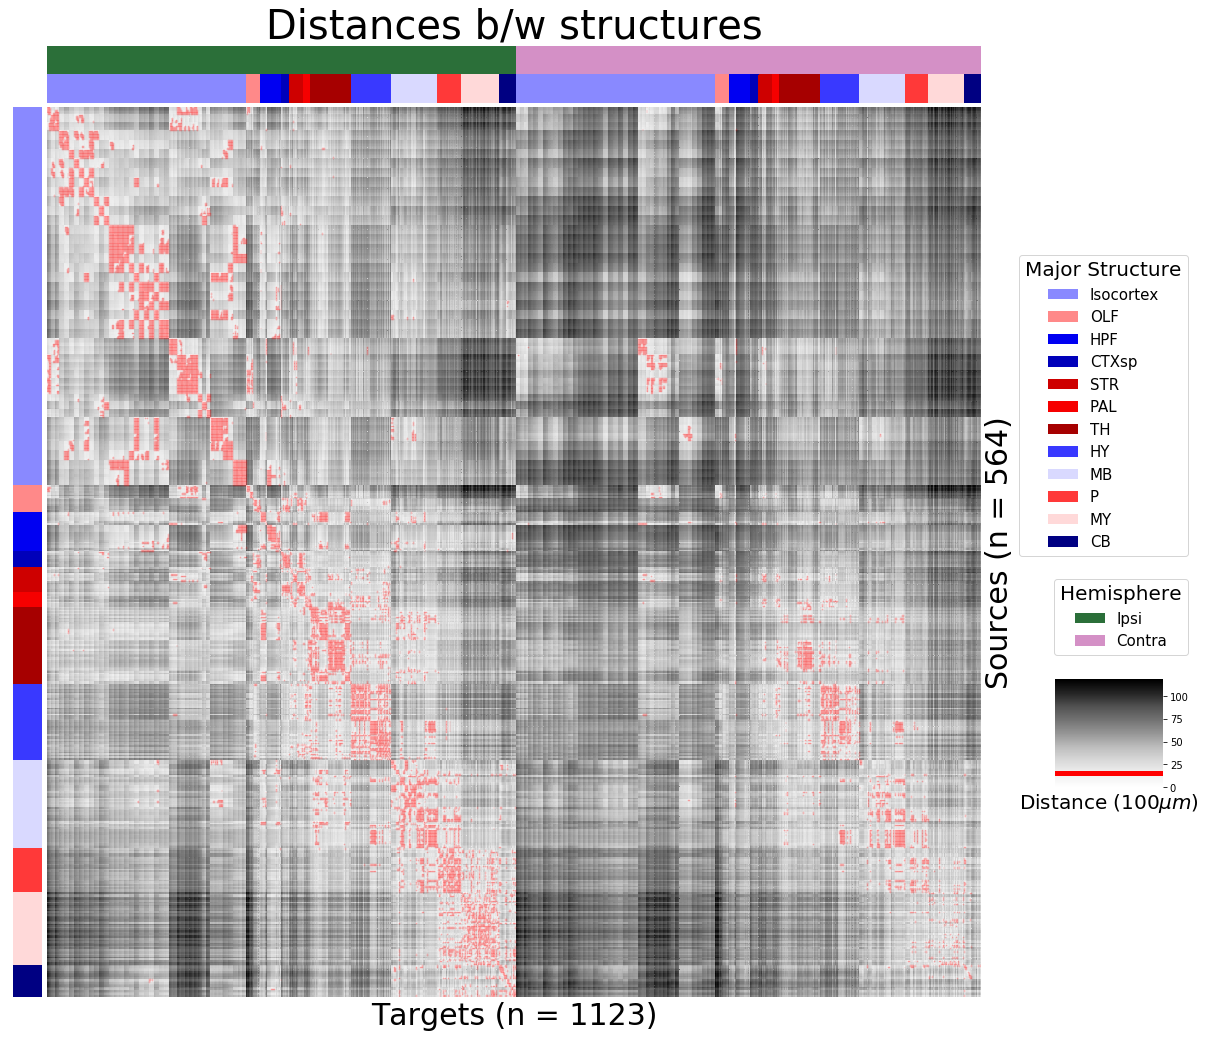

In [22]:
g = sns.clustermap(dists, col_cluster = False, row_cluster = False, 
                   figsize = (15,15), cmap = 'Greys', col_colors = combined_colors_targ, row_colors = combined_colors_source, dendrogram_ratio=0.001)
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets (n = 1123)', fontsize = 30)
g.ax_heatmap.set_ylabel('Sources (n = 564)', fontsize = 30)
ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .5), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

g.ax_cbar.set_xlabel('Distance ' +  r'$(100 \mu m)$', rotation=0, fontsize = 20)
g.ax_cbar.set_position([.98,0.3,.1,.1])
g.ax_cbar.axhline(15, color = 'red', linewidth = 5)
g.ax_col_colors.set_title('Distances b/w structures', fontsize = 40)
for i in range(low_values.shape[0]):
    #print(i)
    g.ax_heatmap.add_patch(Rectangle((low_values[i][1],low_values[i][0]), 1, 1, fill=False, edgecolor='red', lw=.15))

g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/figures/distances_leafs.png', bbox_inches = 'tight',pad_inches = 0)




In [15]:
train_err = []
test_err = []
nrep = 2
tr_results = np.zeros((nrep,25))
te_results = np.zeros((nrep,25))
for n in range(1,25):
    print(n)
    for r in range(nrep):
        #print(r)
        tr_results[r,n] , te_results[r,n] = cv_nmf_missing(data, n_components = n ,alpha=0.0, l1_ratio = 1.,p_holdout = .3)

1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

5


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

12


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

13


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

14


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

15


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; s

16


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

17


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

18


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

19


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

20


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

21


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

22


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

23


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

24


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is 

In [16]:
splits = np.asarray(['Train','Test'])

In [17]:
colorsplits = {}
colorsplits['Train'] = 'red'
colorsplits['Test']=  'blue'

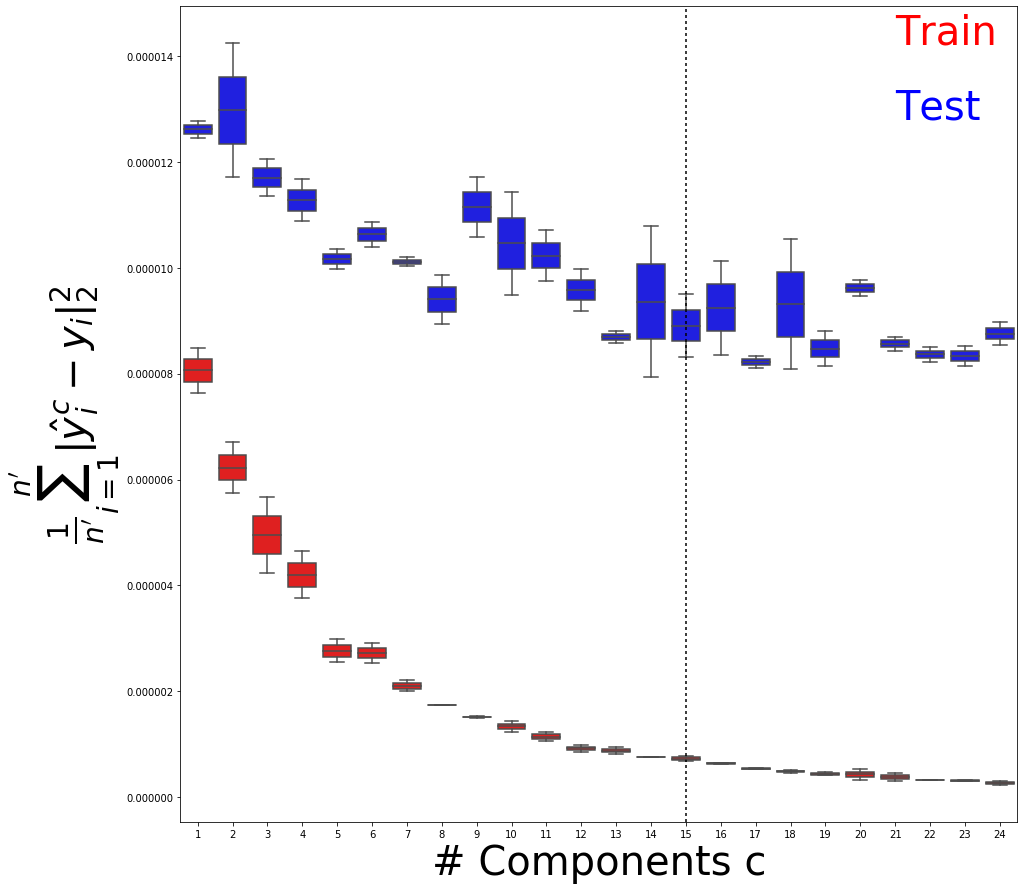

In [19]:
fig , ax = plt.subplots(figsize = (15,15))
sns.boxplot( data = te_results[:,1:], ax=  ax, color= 'blue')
sns.boxplot( data = tr_results[:,1:], ax=  ax, color= 'red')
ax.set_xticklabels(list(range(1,25)))
ax.axvline(14, color='k', dashes=[2,2])
ax.text(20,np.nanmax(te_results[:,1:]), 'Train',color = 'red', fontsize = 40)
ax.text(20,.9*np.nanmax(te_results[:,1:]), 'Test',color = 'blue', fontsize = 40)
ax.set_ylabel(r"$\frac{1}{n'} \sum_{i = 1}^{n'}  \|\hat y_i^c - y_i\|_2^2$", fontsize = 40)
ax.set_xlabel('# Components c', fontsize = 40)
fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/test_train_0603.png', bbox_inches = 'tight',
   pad_inches = 0)
#ax.legend()

In [20]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]
ids.shape

(187,)

In [21]:
ncomp = 15
nreps = 10
components = np.zeros((nreps,ncomp,1123))
for r in range(nreps):
    print(r)
    nmf = NMF(n_components=ncomp, alpha=.001, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
    nmf.fit(data[ids])
    components[r] = nmf.components_

0


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:2464: ConvergenceWarning: Maximum number of iteration 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5
6


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_min is deprecated; safe_min is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
#     nmf = NMF(n_components=ncomp, alpha=.02, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
#     nmf.fit(data[ids])
#     components[r] = nmf.components_
# from sklearn.decomposition._nmf import NMF
# nmf = NMF(n_components=1, alpha=.0, l1_ratio=1., solver='mu', init = 'random', max_iter=500)
# nmf.fit(data[ids][4:10,2:4])
# nmf.fit_transform(data[ids][4:10,2:4])
#data[ids].shape
#nmf.components_
#nmf.components_
#np.nanmax(nmf.components_)

In [24]:
combined = rearrange(components, 'r c p -> (r c) p')
nclusts = np.asarray([15,20,25,30,35])
nreps_cluster = 25

In [25]:
np.nanmax(data[ids])

0.5862357020378113

In [26]:
results = np.zeros(nclusts.shape[0])
for d in range(len(nclusts)):
    print(d)
    nclust = nclusts[d]
    cluster_reps = np.zeros((nreps_cluster,combined.shape[0]))
    for c in range(nreps_cluster):
        
        kmeans  = cluster.KMeans(n_clusters=nclust)
        kmeans.fit(combined)
        clusts = kmeans.labels_[kmeans.labels_.argsort()]
        cluster_reps[c] = kmeans.labels_
        
        
        rands = np.zeros((nreps_cluster,nreps_cluster))
        rands[:] = np.nan
    for i in range(nreps_cluster):
        print(i)
        for j in range(nreps_cluster):
            if i != j:
                rands[i,j] = metrics.adjusted_rand_score(cluster_reps[i], cluster_reps[j])
                    
    results[d] = np.nanmean(rands)
        #print(kmeans.inertia_)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [27]:
results

array([0.82858594, 0.86169113, 0.9091643 , 0.91109223, 0.93963798])

In [28]:
nclust = 25
kmeans  = cluster.KMeans(n_clusters=nclust)
kmeans.fit(combined)
clusts = kmeans.labels_[kmeans.labels_.argsort()]
cclusts = Counter(clusts)
topclusts  = np.asarray(list(cclusts.keys()))[np.asarray(list(cclusts.values())).argsort()][-15:]

In [29]:
top_clust_inds = np.where(np.isin(clusts, topclusts))[0]

In [30]:

#multiind cre_inds, layers, summary
sel_labels = np.zeros(150, dtype = str)
sel_labels[top_clust_inds] = 'Yes'
sel_labels[np.setdiff1d(list(range(150)),top_clust_inds)] = 'No'
rep_labels = np.asarray(np.repeat(list(range(10)),15)[kmeans.labels_.argsort()], dtype = str)
clust_labels = np.asarray(clusts, dtype = str)
row_multi_ind = np.vstack([sel_labels,rep_labels,clust_labels])
row_multi_ind = np.asarray(row_multi_ind, dtype = str)
row_multi_ind_tuples = list(zip(*row_multi_ind))
row_multi_ind_tuples = pd.MultiIndex.from_tuples(row_multi_ind_tuples, names=['Top 15 basis','Replicate', 'Cluster'])

sel_labels = row_multi_ind_tuples.get_level_values('Top 15 basis')
sel_pal = sns.color_palette("cubehelix", n_colors = np.unique(sel_labels).shape[0])
sel_lut = dict(zip(map(str, np.unique(sel_labels)), sel_pal))
sel_colors = pd.Series(sel_labels, index=row_multi_ind_tuples).map(sel_lut)

rep_labels = row_multi_ind_tuples.get_level_values("Replicate")
#rep_labels = pd.Index(rep_labels, dtype = object)#pd.I(rep_labels, index=  np.asarray( list(range(150)) ,dtype = object))
rep_pal = sns.color_palette("cubehelix", n_colors = np.unique(rep_labels).shape[0])
rep_lut = dict(zip(map(str, np.unique(rep_labels)), rep_pal))
rep_colors = pd.Series(rep_labels, index=row_multi_ind_tuples).map(rep_lut)


#clust_labels = pd.DataFrame(clust_labels, index=  np.asarray( list(range(150)) ,dtype = object))
clust_labels = row_multi_ind_tuples.get_level_values("Cluster")
#clust_labels= pd.Index(clust_labels, dtype = object)
clust_pal = sns.color_palette("Paired", np.unique(clust_labels).shape[0]) #sns.cubehelix_palette(summary_labels.unique().size, light=.9, dark=0.1, reverse=False, start=0, rot=-1, hue = 1)#sns.cubehelix_palette(summary_labels.unique().size, light=1., dark=0., reverse=False, start=0, rot=-1, hue = 1)
clust_lut = dict(zip(map(str, np.unique(clust_labels)), clust_pal))
clust_colors = pd.Series(clust_labels, index=row_multi_ind_tuples).map(clust_lut)

arr = np.zeros((150,3), dtype = object)
arr[:,0] = sel_colors
arr[:,1] = rep_colors
arr[:,2] = clust_colors
combined_colors = pd.DataFrame(arr, index = clust_colors.index)

toplot = pd.DataFrame(np.log(combined[kmeans.labels_.argsort()]), index= combined_colors.index)

#fig, ax = plt.subplots(figsize = (15,15))


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


In [31]:
toplot[toplot < -5] = -5

In [32]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

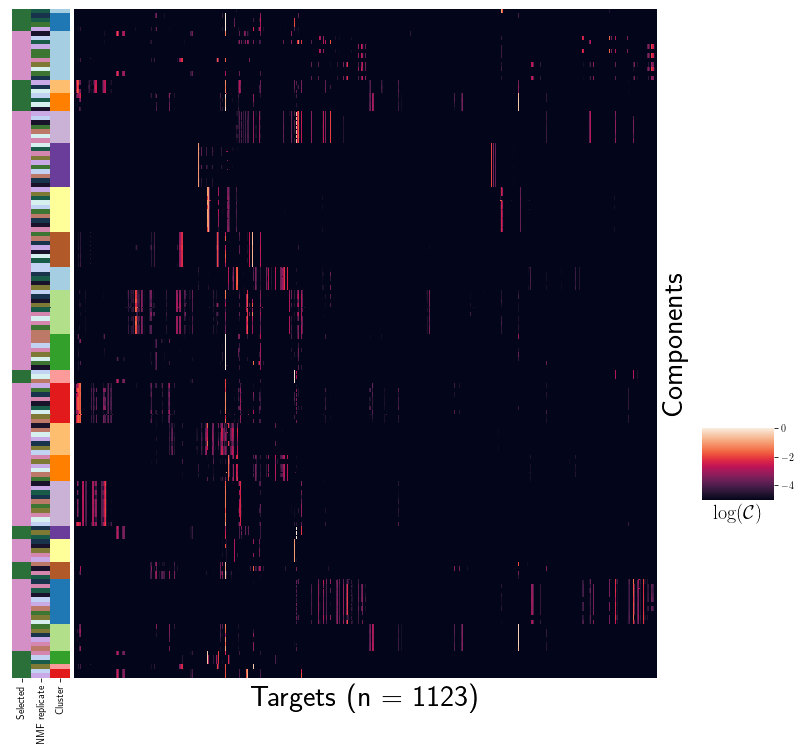

In [33]:
g = sns.clustermap(toplot , vmin = -5, vmax= 0, row_cluster=False, col_cluster=False, row_colors=combined_colors, cbar_pos = [.98,0.3,.1,.1], dendrogram_ratio=0.001)
#g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticklabels(['Selected','NMF replicate','Cluster'])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xlabel('Targets (n = 1123)', fontsize = 30)
g.ax_heatmap.set_ylabel('Components', fontsize = 30)
g.ax_cbar.set_xlabel('$\log(\mathcal C)$', rotation=0, fontsize = 20)
g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/KoelleConnectivity/figs/nmfcluster_0610.png', bbox_inches = 'tight',
   pad_inches = 0)

In [34]:
archetypes = np.zeros((15,wt_conn.shape[1]))
for c in range(15):
    archetypes[c] = np.median(combined[np.where(kmeans.labels_ == topclusts[c])], axis = 0)
    
toplot = np.log(archetypes)
toplot[np.where(toplot< -9)] = -9
toplot = pd.DataFrame(toplot, columns = wt_conn.columns)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


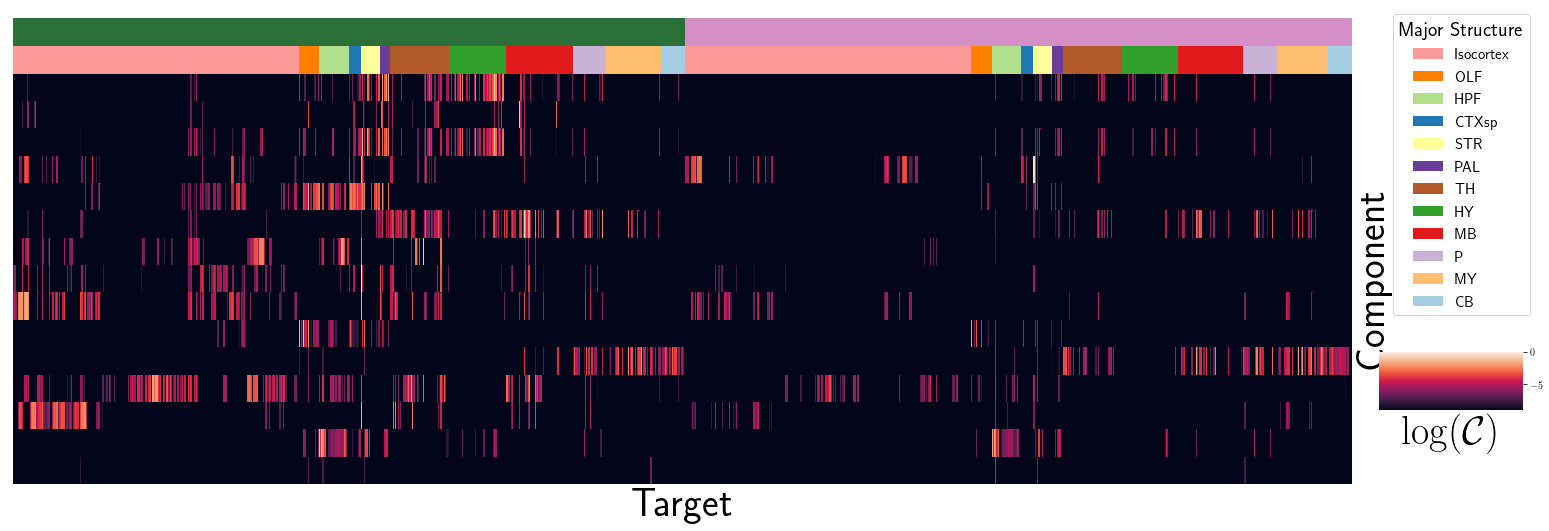

In [36]:
g= sns.clustermap(toplot, 
                  vmin = -9,
                  figsize = (20,8),
                  vmax=  0,
                  col_cluster=False,
                  row_cluster=False,
                  col_colors=combined_colors_targ, cbar_pos = [.96,0.3,.1,.1],colors_ratio=0.06,dendrogram_ratio=0.001)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_ylabel('Component', fontsize = 40)
g.ax_heatmap.set_xlabel('Target', fontsize = 40)
g.ax_heatmap.set_yticks([])
g.ax_col_colors.set_yticks([])
g.ax_cbar.set_xlabel('$\log(\mathcal C)$', rotation=0, fontsize = 40)
# g.ax_col_colors.set_yticks([])
# g.ax_row_colors.set_xticks([])
# g.ax_heatmap.set_xticks([])
# g.ax_heatmap.set_yticks([])
# g.ax_heatmap.set_yticklabels([])
# g.ax_heatmap.set_xticklabels([])
# g.ax_heatmap.set_xlabel('Targets (n = 1123)', fontsize = 30)
# g.ax_heatmap.set_ylabel('Sources (n = 564)', fontsize = 30)
ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.07, 1.), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    

#g.ax_heatmap.set_xticklabels(wt_conn.columns, fontsize = 10)
#g.ax_col_colors.set_xlabel('Summary Structure Targets (n = 621)', fontsize = 40)
# ax = gcf().add_axes((0.6,1.,0.,0.))
# ax.xaxis.set_visible(False)
# for label in np.asarray(major_structures)[reo]:
#     ax.bar(0, 0, color=ccol_dict[label], label=label, linewidth=0.)
# l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.14, .8), bbox_transform=gcf().transFigure, fontsize = 25,title_fontsize=40)    
# g.ax_heatmap.tick_params(axis='y', labelsize=40)
# g.ax_cbar.set_xlabel(r"$\log (\mathcal C)$", rotation=0, fontsize = 40)
# g.ax_cbar.set_position([1.0,0.4,.1,.1])
# g.ax_col_colors.text(100.,.8, 'Ipsilateral', fontsize = 50, color  = 'fuchsia')
# g.ax_col_colors.text(400.,.8, 'Contralateral', fontsize = 50, color  = 'purple')
# g.ax_col_colors.axvline(311, color = 'fuchsia', linewidth  = 5)
# g.ax_col_colors.arrow(311,.5,-30,0, color = 'fuchsia', linewidth  = 5,head_width=.5, head_length=10)
# g.ax_col_colors.arrow(314,.5,30,0, color = 'purple', linewidth  = 5,head_width=.5, head_length=10)
# g.ax_col_colors.axvline(314, color = 'purple', linewidth  = 5)
#g.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/H_wt', pad_inches = 0)


In [202]:
# g = sns.clustermap(toplot , vmin = -9, vmax= 0, row_cluster=False, col_cluster=False, row_colors=combined_colors)

# ax = gcf().add_axes((0.55,1.,0.,0.))
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# for label in np.unique(sel_labels):
#     ax.bar(0, 0, color=sel_colors[label], label=label, linewidth=0.)
# l4 = ax.legend(title='Included', ncol=1, bbox_to_anchor=(1.11, .8), bbox_transform=gcf().transFigure, fontsize = 15,title_fontsize=20)    
